In [1]:
import os
print(os.getcwd())
os.chdir('../Poisson')
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.special as special

C:\Users\rtelang\Box\BIDA_S24\Poisson


## Data Cleaning

In [2]:
df = pd.read_excel('billboard_data.xlsx', header=0)
df.head(10)

,exposure (x),number of users (N)
0,0,48
1,1,37
2,2,30
3,3,24
4,4,20
5,5,16
6,6,13
7,7,11
8,8,9
9,9,7


We want every observation corresponds to a user

In [3]:

exposures = df.values
exposures = np.repeat(exposures[:, 0],exposures[:,1])
df_l = pd.DataFrame(exposures, columns=["exposures"])
df_l

,exposures
0,0
1,0
2,0
3,0
4,0
...,...
245,20
246,20
247,21
248,22


# Poisson regression

In [4]:
Poisson_results = sm.poisson("exposures~1", df_l).fit()

Optimization terminated successfully.
         Current function value: 3.716176
         Iterations 1


In [5]:
print(Poisson_results.summary())

                          Poisson Regression Results                          
Dep. Variable:              exposures   No. Observations:                  250
Model:                        Poisson   Df Residuals:                      249
Method:                           MLE   Df Model:                            0
Date:                Tue, 13 Feb 2024   Pseudo R-squ.:                   0.000
Time:                        09:22:55   Log-Likelihood:                -929.04
converged:                       True   LL-Null:                       -929.04
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4943      0.030     49.873      0.000       1.436       1.553


In [6]:
## prediction 
Poisson_predictions = Poisson_results.predict(df_l)
Poisson_predictions 

0      4.456
1      4.456
2      4.456
3      4.456
4      4.456
       ...  
245    4.456
246    4.456
247    4.456
248    4.456
249    4.456
Length: 250, dtype: float64

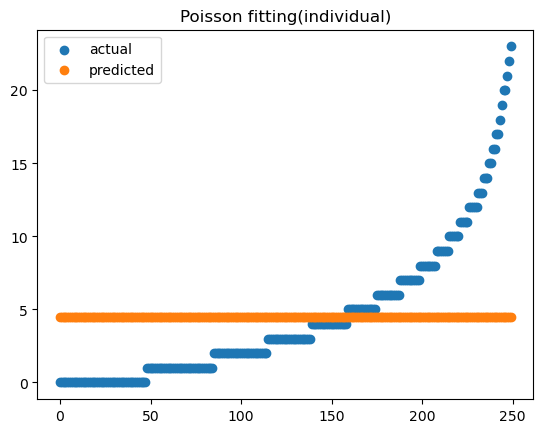

In [7]:
## prediction on the individual level
plt.scatter(df_l.index, df_l.exposures, label="actual")
plt.scatter(df_l.index, Poisson_predictions, label="predicted")
plt.title("Poisson fitting(individual)")
plt.legend()
plt.show()

prediction at individual level is just the mean which is same for all individuals.

We plot the distribution of visits given the mean. Here we calculate the probability of i=1,,n number of visits based on the mean rate $\lambda = 4.45$. If we multily this probability by sample size n =250, we can calculate the number of users making i=1,,n visits.

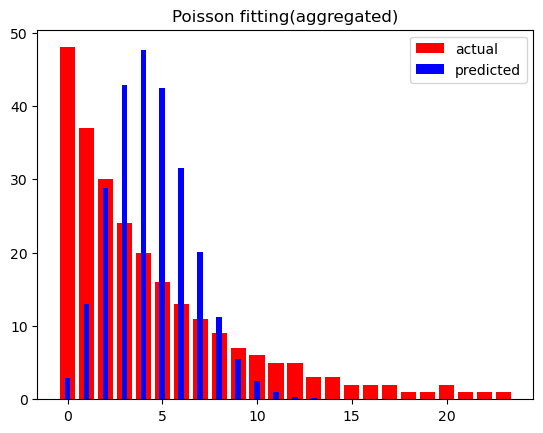

In [8]:

## plot range between 0 and max of exposures in the actual data 
x_range = np.arange(np.max(df.iloc[:,0])+1)
lmbda = np.exp(Poisson_results.params)
predicted_count = stats.poisson.pmf(x_range, lmbda)* len(exposures)
plt.bar(df.iloc[:,0],df.iloc[:,1], color='red', label="actual")
plt.bar(x_range, predicted_count,color='blue',width=0.3, label = "predicted") 
plt.title("Poisson fitting(aggregated)")

plt.legend()
plt.show()

In [19]:
x_range

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [9]:
stats.poisson.pmf(x_range, lmbda)*250

array([2.90217634e+00, 1.29320978e+01, 2.88127138e+01, 4.27964843e+01,
       4.76752835e+01, 4.24882127e+01, 3.15545793e+01, 2.00867436e+01,
       1.11883162e+01, 5.53945966e+00, 2.46838322e+00, 9.99919604e-01,
       3.71303480e-01, 1.27271408e-01, 4.05086710e-02, 1.20337759e-02,
       3.35140658e-03, 8.78462807e-04, 2.17468348e-04, 5.10020505e-05,
       1.13632569e-05, 2.41117488e-06, 4.88372513e-07, 9.46168660e-08])

If the campaign is run for 4 weeks then new mean will be $4\lambda\$. Pediction for 4 weeks is

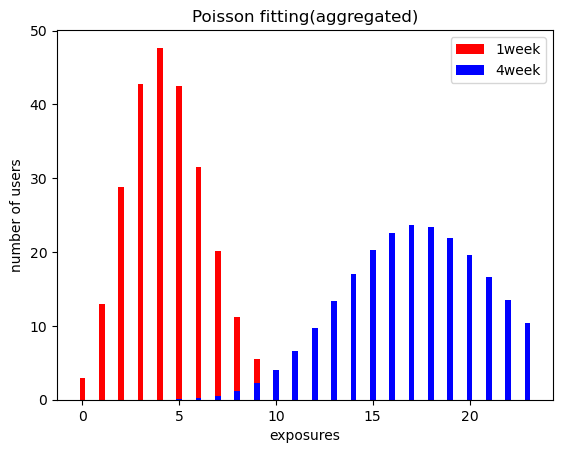

In [10]:
predicted_count4L = stats.poisson.pmf(x_range, lmbda*4)* len(exposures)
plt.bar(x_range, predicted_count,color='red',width=0.3, label = "1week") 
plt.bar(x_range, predicted_count4L,color='blue',width=0.3, label = "4week") 
plt.title("Poisson fitting(aggregated)")

plt.xlabel('exposures')
plt.ylabel('number of users')
plt.legend()
plt.show()

## NBD Regression

In [11]:
NBD_results = sm.negativebinomial("exposures~1", df_l).fit()

Optimization terminated successfully.
         Current function value: 2.598755
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5


In [12]:
print(NBD_results.summary())

                     NegativeBinomial Regression Results                      
Dep. Variable:              exposures   No. Observations:                  250
Model:               NegativeBinomial   Df Residuals:                      249
Method:                           MLE   Df Model:                            0
Date:                Mon, 02 Oct 2023   Pseudo R-squ.:               6.499e-12
Time:                        10:11:43   Log-Likelihood:                -649.69
converged:                       True   LL-Null:                       -649.69
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4943      0.071     21.080      0.000       1.355       1.633
alpha          1.0317      0.121      8.539      0.000       0.795       1.269


In [13]:
NBD_predictions = NBD_results.predict(df_l)

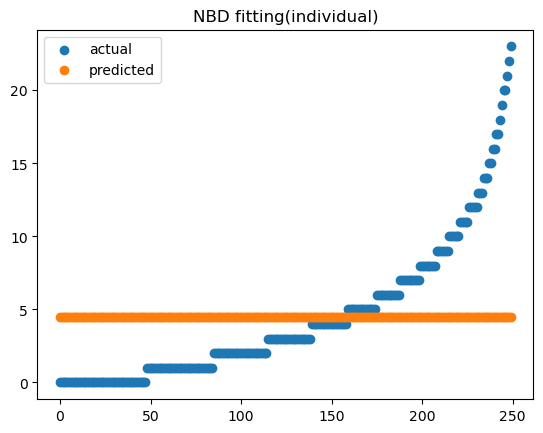

In [14]:
## prediction on the individual level
plt.scatter(df_l.index, df_l.exposures, label="actual")
plt.scatter(df_l.index, NBD_predictions, label="predicted")
plt.title("NBD fitting(individual)")

plt.legend()
plt.show()

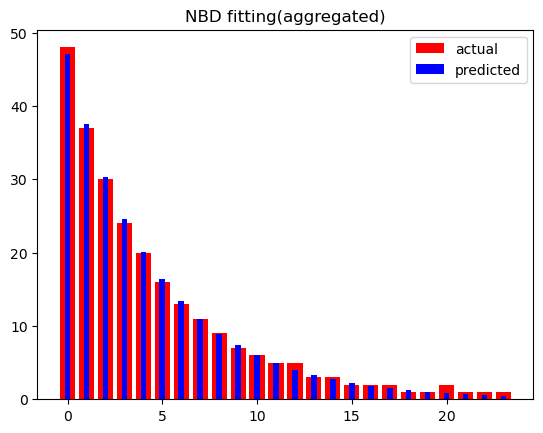

In [16]:
## prediction on the aggregated level 
x_range = np.arange(np.max(exposures)+1)
## ref:
## https://www.statsmodels.org/stable/generated/statsmodels.genmod.families.family.NegativeBinomial.html
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.nbinom.html
mu, alpha = NBD_results.params
mu = np.exp(mu)
p = 1/(1+alpha*mu)
n = 1/alpha
NBD_pmf = stats.nbinom.pmf(x_range, n, p)
predicted_count = NBD_pmf* len(exposures)

plt.bar(df.iloc[:,0],df.iloc[:,1], color='red', label="actual")
plt.bar(x_range, predicted_count,color='blue',width=0.3, label = "predicted")
plt.legend()
plt.title("NBD fitting(aggregated)")
plt.show()

In [25]:
p

0.17865680585321658

In [25]:
 stats.nbinom.pmf(2, n, p)*250

30.319023434650028

In [21]:
x_range 

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

In [ ]:
 #Used by me
x_range = np.arange(np.max(exposures)+1)
## ref:
## https://www.statsmodels.org/stable/generated/statsmodels.genmod.families.family.NegativeBinomial.html
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.nbinom.html

n = NBD_results.params['alpha']
p = NBD_results.predict() 
p1 = p[:24]
NBD_pmf = stats.nbinom.pmf(x_range, n, p1)
predicted_count = NBD_pmf* len(exposures)

plt.bar(df.iloc[:,0],df.iloc[:,1], color='red', label="actual")
plt.bar(x_range, predicted_count,color='blue',width=0.3, label = "predicted")
plt.legend()
plt.title("NBD fitting(aggregated)")
plt.show()